<a href="https://colab.research.google.com/github/darshan-analytics/Data-mining-assignment-2/blob/master/segmentation_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pathlib
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
from functools import partial
from tqdm import tqdm_notebook as tqdm
!pip install -U --quiet git+https://github.com/qubvel/segmentation_models
!pip install -U --quiet git+https://github.com/albumentations-team/albumentations
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import albumentations as A

     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 952kB 5.7MB/s 
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [3]:
import tensorflow as tf

In [20]:
url = "https://drive.google.com/uc?id=1PyYRwvEh5bRBlx0v85-y02svSvS523_L"
!gdown {url}
!unzip -q data2.zip
!rm data2.zip

Downloading...
From: https://drive.google.com/uc?id=1PyYRwvEh5bRBlx0v85-y02svSvS523_L
To: /content/data2.zip
107MB [00:01, 66.4MB/s]
replace EG1800_train.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [5]:
data_dir = '/content/images_data_crop/'
data_dir = pathlib.Path(data_dir)
images_list = (data_dir).glob('*.jpg')
images_list = [str(x) for x in images_list]
np.random.shuffle(images_list)
valid_images_idx = np.loadtxt('val.txt',dtype=np.int64)
valid_images_list = np.array(images_list)[valid_images_idx]
train_images_list = set(images_list).difference(valid_images_list)
train_images_list = list(train_images_list)
valid_images_list = list(valid_images_list)
print(len(train_images_list), 'Training images')
print(len(valid_images_list), 'validation images')

1330 Training images
300 validation images


In [6]:
train_images_list

['/content/images_data_crop/02022.jpg',
 '/content/images_data_crop/00030.jpg',
 '/content/images_data_crop/00790.jpg',
 '/content/images_data_crop/02538.jpg',
 '/content/images_data_crop/00445.jpg',
 '/content/images_data_crop/00402.jpg',
 '/content/images_data_crop/02462.jpg',
 '/content/images_data_crop/00243.jpg',
 '/content/images_data_crop/02581.jpg',
 '/content/images_data_crop/01005.jpg',
 '/content/images_data_crop/02401.jpg',
 '/content/images_data_crop/01072.jpg',
 '/content/images_data_crop/00567.jpg',
 '/content/images_data_crop/00776.jpg',
 '/content/images_data_crop/00612.jpg',
 '/content/images_data_crop/02272.jpg',
 '/content/images_data_crop/02490.jpg',
 '/content/images_data_crop/00677.jpg',
 '/content/images_data_crop/00542.jpg',
 '/content/images_data_crop/00254.jpg',
 '/content/images_data_crop/02364.jpg',
 '/content/images_data_crop/02612.jpg',
 '/content/images_data_crop/02446.jpg',
 '/content/images_data_crop/00740.jpg',
 '/content/images_data_crop/02551.jpg',


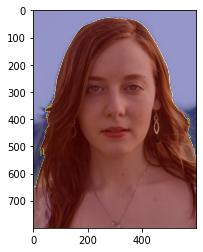

In [7]:
def get_mask_path(path):

  path = str (path)

  new_path = '/'.join(path.split(os.sep)[-2].split('/')[:1]).lower()
  new_path_val = '/'.join(path.split(os.sep)[-1].split('/')[:1]).lower()
  get_val = new_path_val.split(".")[0]

  new_val = "/content" +"/" + "GT_png" +  "/" + get_val  + "_mask.png"

  return new_val

idx = 10
img = PIL.Image.open(train_images_list[idx])
plt.imshow(img)
img = PIL.Image.open(get_mask_path(train_images_list[idx]))
plt.imshow(img, cmap='jet', alpha=0.4)
plt.show()

In [8]:
NCLASSES = 2

In [9]:
train_masks_list = [get_mask_path(x) for x in train_images_list]
valid_masls_list = [get_mask_path(x) for x in valid_images_list]

In [10]:
data_train = tf.data.Dataset.from_tensor_slices((train_images_list, train_masks_list))
data_val = tf.data.Dataset.from_tensor_slices((valid_images_list, valid_masls_list))

In [11]:
BATCH_SIZE = 8
IMG_SIZE = (224, 192)
transforms_train = A.Compose([
            A.Resize(IMG_SIZE[0], IMG_SIZE[1], p=1),
            A.HorizontalFlip(p=0.5),              
            A.RandomSizedCrop(min_max_height=(IMG_SIZE[0]//2, IMG_SIZE[0]), height=IMG_SIZE[0], width=IMG_SIZE[1],
                             w2h_ratio=720/960, p=0.5),
            A.GaussNoise(p=0.1),
            A.IAAPerspective(p=0.4),
            A.MotionBlur(blur_limit=3, p=0.4),
            A.OneOf([A.RandomBrightnessContrast(), A.HueSaturationValue()], p=0.7),
            A.CLAHE(p=0.5)
        ])

transforms_val = A.Compose([
            A.Resize(IMG_SIZE[0], IMG_SIZE[1], p=1)
        ])

BACKBONE = 'efficientnetb0'
preprocess_input = sm.get_preprocessing(BACKBONE)

def aug_fn(image, mask, train):
    data = {"image": image, "mask": mask}
    if train:
      data = transforms_train(**data)
    else:
      data = transforms_val(**data)
    aug_img = data["image"]
    aug_img = preprocess_input(aug_img)
    return aug_img, data["mask"]

def parse(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=1) 
    mask = tf.clip_by_value(mask, clip_value_min=0, clip_value_max=1) #only two classes 0 and 1
    return image, mask

def process_data_train(image, mask):
    aug_img, aug_mask = tf.numpy_function(func=aug_fn, inp=[image, mask, True], 
                                Tout=[tf.float32, tf.uint8])
    aug_img.set_shape(IMG_SIZE+(3,))
    aug_mask = tf.squeeze(aug_mask)
    aug_mask = tf.one_hot(aug_mask,depth=NCLASSES)
    aug_mask.set_shape(IMG_SIZE+(NCLASSES,))
    return aug_img, aug_mask

def process_data_val(image, mask):
    aug_img, aug_mask = tf.numpy_function(func=aug_fn, inp=[image, mask, False], 
                                Tout=[tf.float32, tf.uint8])
    aug_img.set_shape(IMG_SIZE+(3,))
    aug_mask = tf.squeeze(aug_mask)
    aug_mask = tf.one_hot(aug_mask,depth=NCLASSES)
    aug_mask.set_shape(IMG_SIZE+(NCLASSES,))
    return aug_img, aug_mask

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

data_train = data_train.shuffle(buffer_size=BATCH_SIZE*4).map(parse, 
                  num_parallel_calls=AUTOTUNE).cache().map(process_data_train,
                  num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
data_val = data_val.map(parse, 
                  num_parallel_calls=AUTOTUNE).cache().map(process_data_val,
                  num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

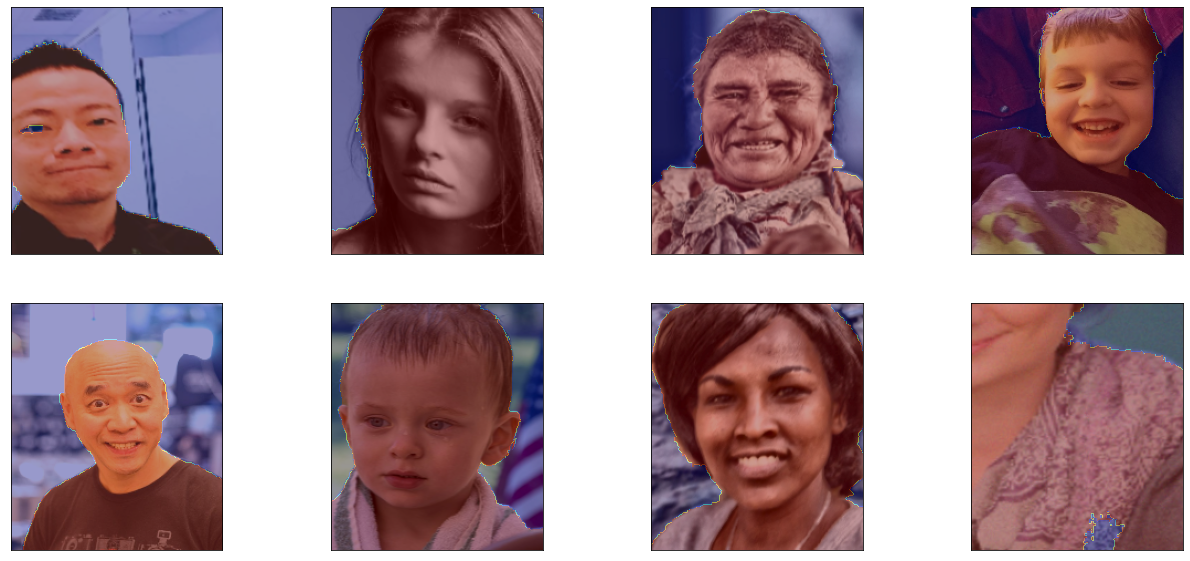

In [13]:
def view_image_batch(ds, model=None):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image, mask = next(iter(ds)) # extract 1 batch from the dataset
    if model is None:
      mask = tf.argmax(mask,axis=-1)
    else:
      mask = tf.argmax(model(image),axis=-1)
    image = np.clip((image.numpy()*std)+mean,0,1) # Doing the efn.preprocess_input inverse 
    fig = plt.figure(figsize=(22, 10))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.imshow(mask[i], cmap='jet', alpha=0.4)

view_image_batch(data_train)

In [14]:
IMG_SHAPE = IMG_SIZE + (3,)




model = sm.Unet('efficientnetb0', input_shape=IMG_SHAPE, classes=NCLASSES, activation='softmax', decoder_block_type='upsampling')

# Fit and checkpoint 
# Load best checkpoint after training

16809984/16804768 [==============================] - 2s 0us/step


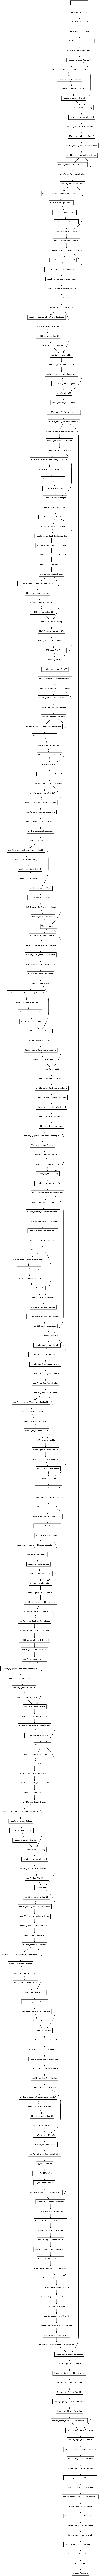

In [15]:
tf.keras.utils.plot_model(model)

In [16]:

filepath = "new_file.hdf5"

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                   save_best_only=True,
                                                   monitor='val_accuracy', 
                                                   save_freq='epoch',
                                                   save_weights_only=True,
                                                   verbose=0)

model.compile(optimizer=tf.keras.optimizers.Adam(),loss=sm.losses.CategoricalFocalLoss(),         metrics="accuracy")



In [17]:
history = model.fit(x=data_train,  validation_data=data_val,  callbacks=[ckpt_callback],
                    epochs=10)

Epoch 1/10
167/167 [==============================] - 1037s 6s/step - loss: 0.0081 - accuracy: 0.9065 - val_loss: 0.0320 - val_accuracy: 0.9098
Epoch 2/10
167/167 [==============================] - 1027s 6s/step - loss: 0.0056 - accuracy: 0.9383 - val_loss: 0.0037 - val_accuracy: 0.9618
Epoch 3/10
167/167 [==============================] - 1023s 6s/step - loss: 0.0041 - accuracy: 0.9563 - val_loss: 0.0033 - val_accuracy: 0.9707
Epoch 4/10
167/167 [==============================] - 1023s 6s/step - loss: 0.0040 - accuracy: 0.9575 - val_loss: 0.0117 - val_accuracy: 0.9458
Epoch 5/10
167/167 [==============================] - 1026s 6s/step - loss: 0.0039 - accuracy: 0.9595 - val_loss: 0.0043 - val_accuracy: 0.9550
Epoch 6/10
167/167 [==============================] - 1024s 6s/step - loss: 0.0037 - accuracy: 0.9614 - val_loss: 0.0029 - val_accuracy: 0.9696
Epoch 7/10
167/167 [==============================] - 1026s 6s/step - loss: 0.0033 - accuracy: 0.9655 - val_loss: 0.0049 - val_accuracy:

In [18]:
model.load_weights(filepath)

PREDICTED


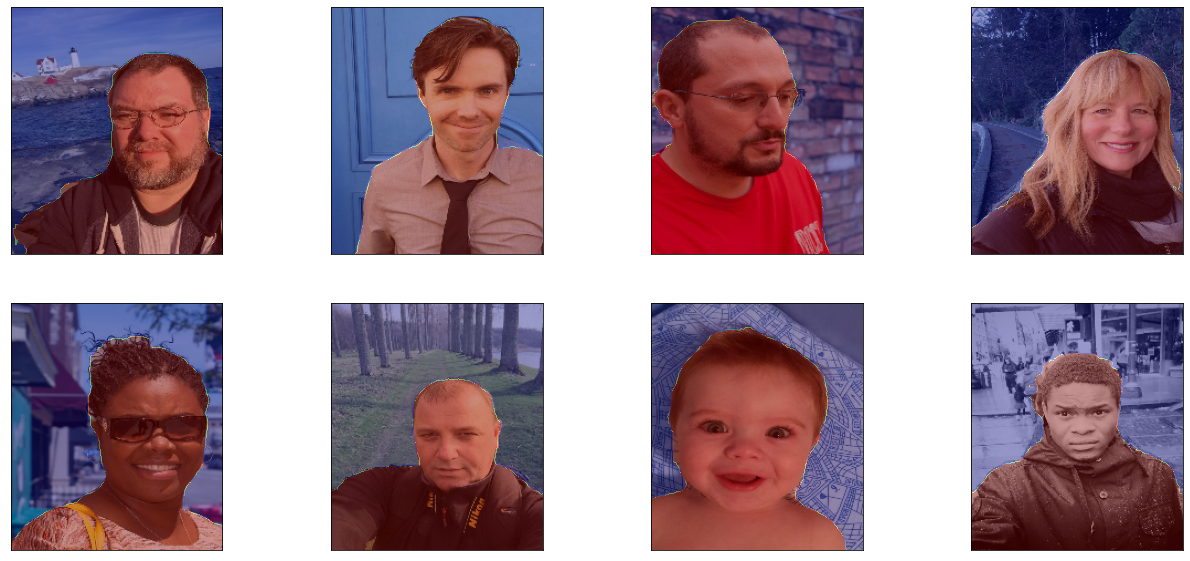

GROUND TRUTH


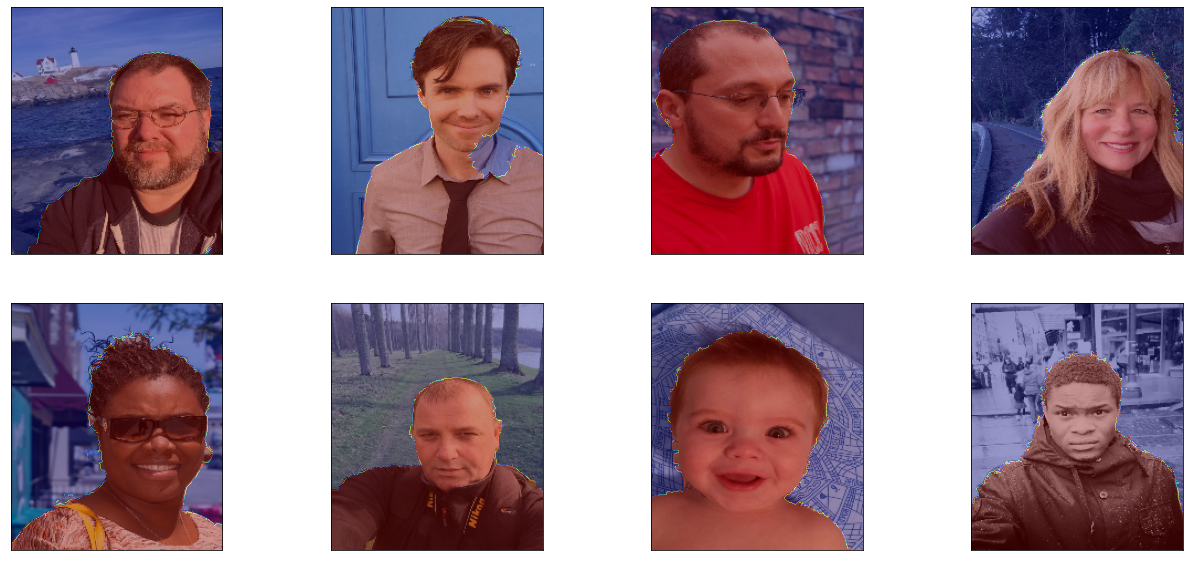

In [19]:
print('PREDICTED')
view_image_batch(data_val, model)
plt.show()
print('GROUND TRUTH')
view_image_batch(data_val)